# Desafio complementar

In [ ]:
import pandas as pd 
import requests
import numpy as np
import seaborn as sns 
from plyer import notification
from datetime import datetime

: 

## 00. Funções auxiliares

In [103]:
def alerta(nivel, base, etapa):
    """
    Retorna um alerta no desktop

    :param nivel: Nível do alerta
    :param base: Base onde ocorreu a falha
    :param etapa: Etapa onde ocorreu a falha

    :type nivel: int
    :type base: str
    :type etapa: str
    """

    niveis = {1:"Baixo",
          2: "Médio",
          3: "Alto"}

    if nivel not in niveis:
        raise ValueError(f"Nível inválido. Deve ser 1, 2 ou 3")


    return notification.notify(title=f"ATENÇÃO: Alerta {niveis[nivel]}",
                               message=f"Falha no carregamento da base {base} na etapa {etapa}\n{datetime.now()}")

def get_req(url, base="base"):
    """
    Retorna o JSON de uma requisição a uma API. Em caso de resposta diferente de 200, retorna um alerta.

    :param url: URL da API
    :param base: Nome da base que será criada

    :type url: str
    :type base: str
    """
    # Trata respostas diferentes da esperada (200)
    req = requests.get(url)
    if req.status_code != 200:
        return alerta(1, base, "Extração")
    
    else:
        return req.json()



## 01. Premissas para extração
Para esta atividade, utilizaremos a API REST Countries

Vamos extrair 3 tabelas a partir da requisição

In [104]:
# Definimos 
url = "https://restcountries.com/v3.1/all"
req = get_req(url)

In [105]:
print(f"Entradas na tabela: {len(req)}")

dados_disponiveis = list(req[0].keys())
print(f"Dados disponíveis: {dados_disponiveis}")



Entradas na tabela: 250
Dados disponíveis: ['name', 'tld', 'cca2', 'ccn3', 'cca3', 'cioc', 'independent', 'status', 'unMember', 'currencies', 'idd', 'capital', 'altSpellings', 'region', 'subregion', 'languages', 'translations', 'latlng', 'landlocked', 'area', 'demonyms', 'flag', 'maps', 'population', 'gini', 'fifa', 'car', 'timezones', 'continents', 'flags', 'coatOfArms', 'startOfWeek', 'capitalInfo', 'postalCode']


## 02. Extração das tabelas 

### 02.01 - Tabela I
Países, regiões e subregiões

,country_id,name,region,subregion
240,240,Rwanda,Africa,Eastern Africa
241,241,North Macedonia,Europe,Southeast Europe
242,242,Kosovo,Europe,Southeast Europe
243,243,Netherlands,Europe,Western Europe
244,244,Tunisia,Africa,Northern Africa
245,245,South Sudan,Africa,Middle Africa
246,246,Honduras,Americas,Central America
247,247,Saint Vincent and the Grenadines,Americas,Caribbean
248,248,Sri Lanka,Asia,Southern Asia
249,249,Hong Kong,Asia,Eastern Asia


<AxesSubplot:xlabel='region', ylabel='Count'>

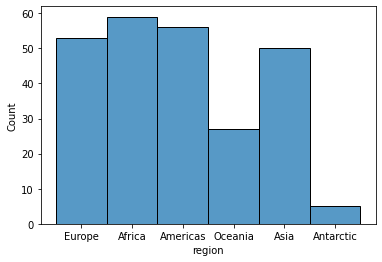

In [106]:
# Considerar escrever uma função que já trate casos de missing values?
# Utilizaremos um country_id único para juntarmos as tabelas posteriormente

country_id = [i for i in range(len(req))]
t1_names = [i["name"]["common"] for i in req]
t1_regions = [i["region"] for i in req]
# Tratamos o caso de não existir a chave "subregion" no JSON da requisição
t1_subregions = [i["subregion"] if "subregion" in i else np.nan for i in req]

df = pd.DataFrame({"country_id": country_id,
                   "name": t1_names,
                   "region": t1_regions,
                   "subregion": t1_subregions})

display(df.tail(10))
sns.histplot(df["region"])

### 02.02 - Tabela II
Nomes oficiais, extensões e população

In [107]:
# Definindo as colunas

t2_names = [i["name"]["official"] for i in req]
t2_extensions = [i["area"] for i in req]
t2_population = [i["population"] for i in req]

# Criando o dicionário que dará origem ao DataFrame

dict_t2 = {"country_id": country_id,
           "name_official": t2_names,
           "extension": t2_extensions,
           "population": t2_population}

df2 = pd.DataFrame(dict_t2)
df2.sort_values("population", ascending=False).head(10)


,country_id,name_official,extension,population
69,69,People's Republic of China,9706961.0,1402112000
219,219,Republic of India,3287590.0,1380004385
88,88,United States of America,9372610.0,329484123
238,238,Republic of Indonesia,1904569.0,273523621
58,58,Islamic Republic of Pakistan,881912.0,220892331
147,147,Federative Republic of Brazil,8515767.0,212559409
212,212,Federal Republic of Nigeria,923768.0,206139587
66,66,People's Republic of Bangladesh,147570.0,164689383
124,124,Russian Federation,17098242.0,144104080
119,119,United Mexican States,1964375.0,128932753


### 02.03 - Tabela III
Nomes e moedas

In [108]:
# Definindo as colunas

t3_names = [i["name"]["common"] for i in req]
t3_currencies = [i["currencies"] if "currencies" in i else np.nan for i in req]
t3_currency_acro = [list(i["currencies"].keys()) if "currencies" in i else np.nan for i in req]

# Criando o dicionário que dará origem ao DataFrame

t3_dict = {"country_id": country_id,
           "name": t3_names,
           "currencies": t3_currency_acro
           }

df3 = pd.DataFrame(t3_dict)
df3.tail(10)

,country_id,name,currencies
240,240,Rwanda,[RWF]
241,241,North Macedonia,[MKD]
242,242,Kosovo,[EUR]
243,243,Netherlands,[EUR]
244,244,Tunisia,[TND]
245,245,South Sudan,[SSP]
246,246,Honduras,[HNL]
247,247,Saint Vincent and the Grenadines,[XCD]
248,248,Sri Lanka,[LKR]
249,249,Hong Kong,[HKD]


## 03 - Tratamento das tabelas

## 03.01 - Tabela 01

Passo 1: entendendo a tabela

In [109]:
display(df.tail())
display(df.info())

,country_id,name,region,subregion
245,245,South Sudan,Africa,Middle Africa
246,246,Honduras,Americas,Central America
247,247,Saint Vincent and the Grenadines,Americas,Caribbean
248,248,Sri Lanka,Asia,Southern Asia
249,249,Hong Kong,Asia,Eastern Asia


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_id  250 non-null    int64 
 1   name        250 non-null    object
 2   region      250 non-null    object
 3   subregion   245 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.9+ KB


None

Vemos que não há muita margem para tratamento nesta tabela específica, então apenas renomearemos as colunas

In [110]:
df_cols_renamed = {"name":"Common Name", "region":"Region", "subregion":"Subregion"}

df = df.rename(columns=df_cols_renamed)

In [111]:
df.tail()

,country_id,Common Name,Region,Subregion
245,245,South Sudan,Africa,Middle Africa
246,246,Honduras,Americas,Central America
247,247,Saint Vincent and the Grenadines,Americas,Caribbean
248,248,Sri Lanka,Asia,Southern Asia
249,249,Hong Kong,Asia,Eastern Asia


### 03.02 - Tabela 02

Passo 1: entendendo a tabela

In [112]:
display(df2.tail())
display(df2.info())

,country_id,name_official,extension,population
245,245,Republic of South Sudan,619745.0,11193729
246,246,Republic of Honduras,112492.0,9904608
247,247,Saint Vincent and the Grenadines,389.0,110947
248,248,Democratic Socialist Republic of Sri Lanka,65610.0,21919000
249,249,Hong Kong Special Administrative Region of the...,1104.0,7500700


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_id     250 non-null    int64  
 1   name_official  250 non-null    object 
 2   extension      250 non-null    float64
 3   population     250 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.9+ KB


None

Conclusão: esta tabela também está de acordo com o que esperamos, inclusive os formatos dos dados. Renomearemos apenas as colunas, novamente.

In [113]:
df2_cols_renamed = {"name_official":"Official Name", "extension":"Extension (sqkm)", "population":"Population"}
df2 = df2.rename(columns=df2_cols_renamed)
df2.tail()

,country_id,Official Name,Extension (sqkm),Population
245,245,Republic of South Sudan,619745.0,11193729
246,246,Republic of Honduras,112492.0,9904608
247,247,Saint Vincent and the Grenadines,389.0,110947
248,248,Democratic Socialist Republic of Sri Lanka,65610.0,21919000
249,249,Hong Kong Special Administrative Region of the...,1104.0,7500700


### 03.03 - Tabela 03

Passo 1: entendendo a tabela

In [114]:
display(df3.tail())
display(df3.info())

,country_id,name,currencies
245,245,South Sudan,[SSP]
246,246,Honduras,[HNL]
247,247,Saint Vincent and the Grenadines,[XCD]
248,248,Sri Lanka,[LKR]
249,249,Hong Kong,[HKD]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_id  250 non-null    int64 
 1   name        250 non-null    object
 2   currencies  247 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.0+ KB


None

Nesta tabela, identificamos 2 possibilidades de tratamento:
- Há missing values na coluna "currencies"
- Os valores na coluna "currencies" estão em formato de lista

Proporemos as seguintes mudanças:
- utilizarmos um valor "N/A" (not applicable)
- utilizaremos a função explode para separarmos os valores das listas de moedas
- mudaremos os nomes das colunas
  

In [115]:
df3[df3["currencies"].isna()]

,country_id,name,currencies
159,159,Bouvet Island,NaN
194,194,Antarctica,NaN
218,218,Heard Island and McDonald Islands,NaN


In [116]:
df3 = df3.fillna("N/A")
df3 = df3.explode("currencies")
df3_cols_renamed = {"name":"Common Name", "currencies":"Currency"}
df3 = df3.rename(columns=df3_cols_renamed)

In [117]:
# Mostrando um exemplo de país com 2 moedas

df3[df3["country_id"] == 149]

,country_id,Common Name,Currency
149,149,"Saint Helena, Ascension and Tristan da Cunha",GBP
149,149,"Saint Helena, Ascension and Tristan da Cunha",SHP


### Apêndice
#### Ideias para o projeto:
- Fazer a tabela 1 extrair TODOS os dados da API, a princípio classificando-os pelo country_id
- Na tabela 3, extrair na verdade todas as moedas do mundo, com nomes, acrônimos e símbolos. Atribuir um id para cada moeda